In [0]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [0]:
%matplotlib inline
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('~/data')
try:
     os.makedirs(local_download_path)
except: pass



In [0]:
file_list_paint = drive.ListFile(
       {'q': "'1OKl_h_UzwpCsLE3gfcKUqqN9pSS_KEHg' in parents"}).GetList()

file_list_photo = drive.ListFile(
       {'q': "'1dcbDfkItaVdNjFA7J1z8p4SFHwmahjSV' in parents"}).GetList()

In [0]:
imsize = 256

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [0]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


In [0]:
from torch.utils.data import DataLoader
batch_size = 25

In [0]:
paint=[]
loaded=0
for img in file_list_paint:
  fname = os.path.join(local_download_path, img['title']).split("/")[-1]
  style_img = image_loader("gdrive/My Drive/vangog_paint/"+fname)
  paint.append(style_img)
  loaded+=1
  print(loaded, "paint")

photo=[]
loaded=0
for img in file_list_photo:
  fname = os.path.join(local_download_path, img['title']).split("/")[-1]
  style_img = image_loader("gdrive/My Drive/vangog_photo/"+fname)
  photo.append(style_img)
  loaded+=1
  print(loaded,"photo")

Streaming output truncated to the last 5000 lines.
1289 photo
1290 photo
1291 photo
1292 photo
1293 photo
1294 photo
1295 photo
1296 photo
1297 photo
1298 photo
1299 photo
1300 photo
1301 photo
1302 photo
1303 photo
1304 photo
1305 photo
1306 photo
1307 photo
1308 photo
1309 photo
1310 photo
1311 photo
1312 photo
1313 photo
1314 photo
1315 photo
1316 photo
1317 photo
1318 photo
1319 photo
1320 photo
1321 photo
1322 photo
1323 photo
1324 photo
1325 photo
1326 photo
1327 photo
1328 photo
1329 photo
1330 photo
1331 photo
1332 photo
1333 photo
1334 photo
1335 photo
1336 photo
1337 photo
1338 photo
1339 photo
1340 photo
1341 photo
1342 photo
1343 photo
1344 photo
1345 photo
1346 photo
1347 photo
1348 photo
1349 photo
1350 photo
1351 photo
1352 photo
1353 photo
1354 photo
1355 photo
1356 photo
1357 photo
1358 photo
1359 photo
1360 photo
1361 photo
1362 photo
1363 photo
1364 photo
1365 photo
1366 photo
1367 photo
1368 photo
1369 photo
1370 photo
1371 photo
1372 photo
1373 photo
1374 photo
137

In [0]:
paint_loader = DataLoader(paint, batch_size=batch_size, shuffle=True)
photo_loader = DataLoader(photo, batch_size=batch_size, shuffle=True)

In [0]:
from torch import nn
import torch
from torch.nn import functional as F
import functools
import itertools

In [0]:
class NLayerDiscriminator(nn.Module):
    def __init__(self):
        super(NLayerDiscriminator, self).__init__()
        self.dis_model = nn.Sequential(
                     nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
                     nn.LeakyReLU(0.2, True),

                     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                     nn.BatchNorm2d(128),
                     nn.LeakyReLU(0.2,True),

                     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                     nn.BatchNorm2d(256),
                     nn.LeakyReLU(0.2,True),

                     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
                     nn.BatchNorm2d(512),
                     nn.LeakyReLU(0.2,True),

                     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

        )
        

    def forward(self, input):
        res=self.dis_model(input)
        return res

In [0]:
class UnetGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.pool0 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.pool1 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,stride=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.pool2 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.pool3 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256,out_channels=256,kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=1)
        self.upsample1 = nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=256,out_channels=64,kernel_size=3,padding=1)
        self.upsample2 = nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=128,out_channels=32,kernel_size=3,padding=1)
        self.upsample3 = nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=64,out_channels=3,kernel_size=3,padding=1)

    def forward(self, x):
        # encoder
        c0 = F.relu(self.enc_conv0(x))
        e0 = self.pool0(c0)
        c1 = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(c1)
        c2 = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(c2)
        c3 = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(c3)

        # bottleneck
        cb=F.relu(self.bottleneck_conv(e3))
        b = self.upsample0(cb)

        # decoder
        conc0 = torch.cat([b, c3],dim=1)
        d0 = self.upsample1(F.relu(self.dec_conv0(conc0)))
        conc1 = torch.cat([d0, c2],dim=1)
        d1 = self.upsample2(F.relu(self.dec_conv1(conc1)))
        conc2 = torch.cat([d1, c1],dim=1)
        d2 = self.upsample3(F.relu(self.dec_conv2(conc2)))
        conc3 = torch.cat([d2, c0],dim=1)
        d3 = self.dec_conv3(conc3)  # no activation
        return d3


In [0]:
class Sample_from_Pool(object):
    def __init__(self):
        self.max_elements = 50
        self.cur_elements = 0
        self.items = []

    def __call__(self, in_items):
        return_items = []
        for in_item in in_items:
            if self.cur_elements < self.max_elements:
                self.items.append(in_item)
                self.cur_elements = self.cur_elements + 1
                return_items.append(in_item)
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_elements)
                    tmp = copy.copy(self.items[idx])
                    self.items[idx] = in_item
                    return_items.append(tmp)
                else:
                    return_items.append(in_item)
        return return_items

In [0]:
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [0]:
def train(genA,genB,discA,discB,a_loader,b_loader,optimaizerG,optimaizerD,schedulerG,shedulerD,mse,l1,epochs=100,lamda=10,idt_coef=0.5):
    a_fake_sample = Sample_from_Pool()
    b_fake_sample = Sample_from_Pool()
    discA_losses_total=[]
    discB_losses_total=[]
    gen_losses_total=[]
    for epoch in range(epochs):
        discA_losses=[]
        discB_losses=[]
        gen_losses=[]
        print('* Epoch %d/%d' % (epoch+1, epochs))
        for i, (a_real, b_real) in enumerate(zip(a_loader, b_loader)):
                for param in discA.parameters():
                    param.requires_grad = False
                for param in discB.parameters():
                    param.requires_grad = False

                optimaizerG.zero_grad()

                a_real = Variable(a_real[0])
                b_real = Variable(b_real[0])
                a_real, b_real = a_real.to(device), b_real.to(device)

                a_fake = genA(b_real)
                b_fake = genB(a_real)

                a_recon = genA(b_fake)
                b_recon = genB(a_fake)

                a_idt = genA(a_real)
                b_idt = genB(b_real)

                a_idt_loss = l1(a_idt, a_real) * lamda * idt_coef
                b_idt_loss = l1(b_idt, b_real) * lamda * idt_coef

                a_fake_dis = discA(a_fake)
                b_fake_dis = discB(b_fake)

                real_label = Variable(torch.ones(a_fake_dis.size())).to(device)

                a_gen_loss = mse(a_fake_dis, real_label)
                b_gen_loss = mse(b_fake_dis, real_label)

                a_cycle_loss = l1(a_recon, a_real) * lamda
                b_cycle_loss = l1(b_recon, b_real) * lamda

                gen_loss = a_gen_loss + b_gen_loss + a_cycle_loss + b_cycle_loss + a_idt_loss + b_idt_loss
                gen_losses.append(gen_loss)

                gen_loss.backward()
                optimaizerG.step()

                for param in discA.parameters():
                    param.requires_grad = True
                for param in discB.parameters():
                    param.requires_grad = True

                optimaizerD.zero_grad()

                a_fake = Variable(torch.Tensor(a_fake_sample([a_fake.cpu().data.numpy()])[0]))
                b_fake = Variable(torch.Tensor(b_fake_sample([b_fake.cpu().data.numpy()])[0]))
                a_fake, b_fake = a_fake.to(device),b_fake.to(device)

                a_real_dis = discA(a_real)
                a_fake_dis = discA(a_fake)
                b_real_dis = discB(b_real)
                b_fake_dis = discB(b_fake)
                real_label = Variable(torch.ones(a_real_dis.size())).to(device)
                fake_label = Variable(torch.zeros(a_fake_dis.size())).to(device)

                a_dis_real_loss = mse(a_real_dis, real_label)
                a_dis_fake_loss = mse(a_fake_dis, fake_label)
                b_dis_real_loss = mse(b_real_dis, real_label)
                b_dis_fake_loss = mse(b_fake_dis, fake_label)

                a_dis_loss = (a_dis_real_loss + a_dis_fake_loss)*0.5
                b_dis_loss = (b_dis_real_loss + b_dis_fake_loss)*0.5
                discA_losses.append(a_dis_loss)
                discB_losses.append(b_dis_loss)

                a_dis_loss.backward()
                b_dis_loss.backward()
                optimaizerD.step()

                print("Epoch: (%3d) (%5d/%5d) | Gen Loss:%.2e | Dis Loss:%.2e" % 
                                            (epoch, i + 1, min(len(a_loader), len(b_loader)),
                                                            gen_loss,a_dis_loss+b_dis_loss))

                schedulerG.step()
                schedulerD.step()
        if (epoch+1)%10==0:
                  torch.save(genA.state_dict(), "gdrive/My Drive/gog_genA"+str(epoch+1)+".pth")
                  torch.save(genB.state_dict(), "gdrive/My Drive/gog_genB"+str(epoch+1)+".pth")
                  torch.save(discA.state_dict(), "gdrive/My Drive/gog_discA"+str(epoch+1)+".pth")
                  torch.save(discB.state_dict(), "gdrive/My Drive/gog_discB"+str(epoch+1)+".pth") 
        gen_losses_total.append(torch.mean(torch.Tensor(gen_losses))) 
        discA_losses_total.append(torch.mean(torch.Tensor(discA_losses))) 
        discB_losses_total.append(torch.mean(torch.Tensor(discB_losses)))
    return gen_losses_total, discA_losses_total, discB_losses_total

In [0]:
import numpy as np

In [0]:
epochs=20
genA = UnetGenerator()
genB = UnetGenerator()
discA = NLayerDiscriminator()
discB = NLayerDiscriminator()

optimaizerG = torch.optim.Adam(itertools.chain(genA.parameters(),genB.parameters()), lr=.0002, betas=(0.5, 0.999))
optimaizerD = torch.optim.Adam(itertools.chain(discA.parameters(),discB.parameters()), lr=.0002, betas=(0.5, 0.999))


schedulerG = torch.optim.lr_scheduler.StepLR(optimaizerG, 40, 0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimaizerD, 40, 0.5)
mse = nn.MSELoss()
l1 = nn.L1Loss()

In [0]:
gen_losses, discA_losses, discB_losses=train(genA,genB,discA,discB,photo_loader,paint_loader,optimaizerG,optimaizerD,schedulerG,schedulerD,mse,l1,epochs=epochs)

* Epoch 1/20
Epoch: (  0) (    1/   16) | Gen Loss:1.46e+01 | Dis Loss:1.40e+00
Epoch: (  0) (    2/   16) | Gen Loss:1.16e+01 | Dis Loss:2.31e+00
Epoch: (  0) (    3/   16) | Gen Loss:1.78e+01 | Dis Loss:3.04e+00
Epoch: (  0) (    4/   16) | Gen Loss:1.23e+01 | Dis Loss:1.68e+00
Epoch: (  0) (    5/   16) | Gen Loss:1.53e+01 | Dis Loss:7.70e-01
Epoch: (  0) (    6/   16) | Gen Loss:1.46e+01 | Dis Loss:1.15e+00
Epoch: (  0) (    7/   16) | Gen Loss:1.61e+01 | Dis Loss:7.97e-01
Epoch: (  0) (    8/   16) | Gen Loss:1.37e+01 | Dis Loss:6.57e-01
Epoch: (  0) (    9/   16) | Gen Loss:1.55e+01 | Dis Loss:3.78e-01
Epoch: (  0) (   10/   16) | Gen Loss:1.29e+01 | Dis Loss:3.81e-01
Epoch: (  0) (   11/   16) | Gen Loss:1.45e+01 | Dis Loss:4.11e-01
Epoch: (  0) (   12/   16) | Gen Loss:1.29e+01 | Dis Loss:4.45e-01
Epoch: (  0) (   13/   16) | Gen Loss:8.22e+00 | Dis Loss:3.73e-01
Epoch: (  0) (   14/   16) | Gen Loss:8.62e+00 | Dis Loss:5.82e-01
Epoch: (  0) (   15/   16) | Gen Loss:1.29e+01 | 

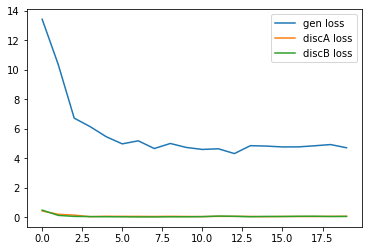

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(len(gen_losses)), gen_losses, label='gen loss')
plt.plot(range(len(discA_losses)), discA_losses, label='discA loss')
plt.plot(range(len(discB_losses)), discB_losses, label='discB loss')
plt.legend()
plt.show()

In [0]:
a_real_test = Variable(iter(photo_loader).next()[0], requires_grad=True)
b_real_test = Variable(iter(paint_loader).next()[0], requires_grad=True)
a_real_test, b_real_test = a_real_test.to(device), b_real_test.to(device)
        

genA.eval()
genB.eval()

with torch.no_grad():
    a_fake_test = genA(b_real_test)
    b_fake_test = genB(a_real_test)
    a_recon_test = genA(b_fake_test)
    b_recon_test = genB(a_fake_test)

pic = (torch.cat([a_real_test, b_fake_test, a_recon_test, b_real_test, a_fake_test, b_recon_test], dim=0).data+0.5) / 2.0



In [0]:
import torchvision

In [0]:
torchvision.utils.save_image(pic, 'gdrive/My Drive/vangog_sample_result'+str(epochs)+'.jpg', nrow=3)